# Poisson HMM Demo

Written by Benjamin Antin, Scott Linderman, and Krishna Shenoy.
Thanks to [Caleb Kemere](http://rnel.rice.edu/) for sharing his data with us.
  
## Applying an HMM to electrophysiology data from a motor-control task

In this notebook, we'll show how SSM can be used for modeling neuroscience data. This notebook is based off the 2008 paper ["Detecting Neural-State Transitions Using Hidden Markov Models for Motor Cortical Prostheses"](https://web.stanford.edu/~shenoy/GroupPublications/KemereEtAlJNeurophysiol2008.pdf) by Caleb Kemere _et al_.  

  
Kemere shows that an HMM can be used to detect neural transitions in a reaching task performed by a monkey. Crucially, by cleverly configuring the HMM states, the authors are also able to decode which target the monkey reached to using their trained HMM. See the paper for more details on the data and experimental set-up.
  
First, we need to load in the data. Though the data is not yet publicly available, we are hoping to make it available soon. We will assume that you have the dependencies included in SSM installed.

In [1]:
from scipy.linalg import block_diag
import autograd.numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import ssm

%matplotlib inline

## 1. Background

This dataset contains neural recordings made using a Utah array (96 electrodes) implanted in pre-motor cortex a macaque performing a reach task.
During the task, the monkey must reach to one of 8 targets, as indicated by a cue on a screen.
Each trial consists of 3 phases: a **baseline** phase, a **plan** phase, and a **move** phase.
We describe these phases below:

1. **baseline**: The animal fixates and places his hand in the center of the screen.
2. **plan**: A target appears in one of 8 locations (radially spread out from the center of the screen).
The monkey does not yet begin reaching.
3. **move**: A go-cue comes on, telling the monkey to begin his reach. Upon successfully reaching the target, the monkey receives a liquid reward.

The neural data has been spike-sorted and binned in 10ms intervals.  
  
**Note**: This data contains both single and multi-unit spiking activity. We'll be loose with terminology and use the term "neuron" and "unit" interchangeably here.

## 2. Load the dataset

The dataset is provided as a numpy .npz archive with the following variables:
  
1. `FR`: A numpy array of (neuron, time-bin, trial) with size (190, 155, 1127). The trials have already been time aligned, such that the plan and movement periods begin in the same time-bin for all of the 1127 trials.
2. `base_idx`: Indices of time-bins corresponding to the baseline period (see Section #1).
3. `plan_idx`: Indices of time-bins corresponding to the plan period.
4. `move_idx`: Indices of time-bins corresponding to the movement period.
5. `targets`: Length 8 list of the x,y coordinates for each of the 8 targets.
5. `target_idx`: A nested list, where `cInds[0]` is list of all trials to target 1, `cInds[1]` is a list of all trials to target 2, etc.
5. `train_idx`: Indices of the trials we will use for training.
5. `test_idx`: Indices of the trials we will use for testing.
  
  
Below, after we pull out the data, we visualize the spike data for the first trials.
We see that there is a noticeable increase in neural activity when the movement period starts.

In [2]:
DATA_PATH = "/Users/Bantin/Documents/Stanford/Linderman-Shenoy/Kemere2008/extracted_data/H1217/H1217_hmm_data.npz"
vars_dict = np.load(DATA_PATH, allow_pickle=True)

In [3]:
FR = vars_dict['FR']
base_idx = vars_dict['base_idx']
plan_idx = vars_dict['plan_idx']
move_idx = vars_dict['move_idx']
targets = vars_dict['targets']
target_idx = vars_dict['target_idx']
train_idx = vars_dict['train_idx']
test_idx = vars_dict['test_idx']

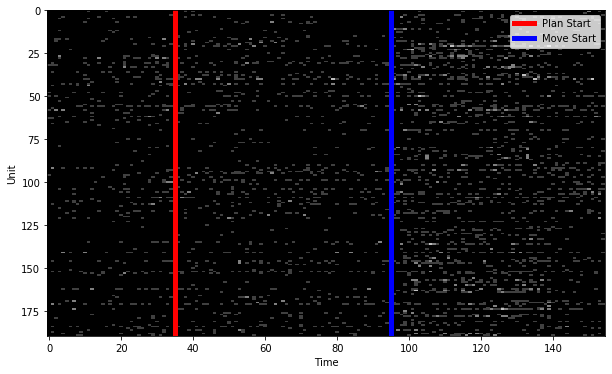

In [4]:
# Display a spike raster of the image
plt.figure(figsize=(10,6))
plt.imshow(FR[:,:,1], aspect='auto', cmap='gray')
#plt.axis('off')

# Label the different phases of the trial movement activity
time_bins = FR.shape[1]
plan_start = plan_idx[0]
move_start = move_idx[0]

plt.axvline(x=plan_start, color='red', linewidth=5, label='Plan Start')
plt.axvline(x=move_start, color='blue', linewidth=5, label='Move Start')
plt.ylabel("Unit")
plt.xlabel("Time")
plt.legend()
plt.tight_layout
plt.show()

## 3. Visualize the Targets
To get a sense of the task, we'll visualize the 8 targets used in the task. Inspecting the `targets` array, we see 
8 pairs of (x, y) coordinates. These correspond to the location of the 8 targets on the screen.

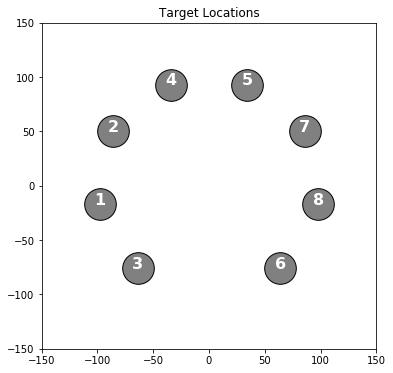

In [5]:
num_targets = len(targets)
xlist = [target[0] for target in targets]
ylist = [target[1] for target in targets]
plt.figure(figsize=(6,6))
plt.scatter(xlist,
            ylist,
            marker='o',
            s=10**3,
            edgecolors='black',
            facecolors='gray')
plt.xlim(-150, 150)
plt.ylim(-150, 150)

for i in range(num_targets):
    plt.annotate(str(i+1),
                 (xlist[i] - 5, ylist[i]),
                 color='white',
                 weight='bold',
                 size=16)
plt.title("Target Locations")
plt.show()

## 4. Fit a simple 3-state HMM
As a first step, we'll fit a simple 3 state HMM to the training data. For this, we're not aiming to actually decode which target the monkey reached to, we're merely going to check if we can uncover the the 3 phases of the reach (baseline, plan, move) in an unsupervised way using an HMM.
  
### 4.1 Format the data for SSM
When calling SSM's `fit` function, the data is expected to be formatted as a list `datas` where `datas[i]` is a 2D array of size `time_bins X observations`. Here, we'll reformat our data to match this. For us, this means that each entry of datas should be a `time_bins X 190`, because we have 190 neurons.


In order for the following steps to make sense, we need to give more details about how the `FR` array is arranged. As mentioned, it is formatted as (neurons, time, trials). However, not every trial in the dataset is actually the same length -- this is because the length of the delay period is randomized, and it takes the monkey varying amounts of time to reach the target.  

To acount for this, the `FR` array has been padded with NaNs so that all trials have the same length. This is very helpful, because it makes it easy to know which time bins correspond to each phase of the task. 
However, for our purposes, we don't want to include the NaNS when fitting our HMM (in fact, SSM will throw an error if we do). 
Instead, we will remove the columns of FR which contain NaNs, and create a list that matches the format above.

In [41]:
def format_spikes(FR, idx):
    datas = []
    for i in idx:
        spikes_cur = np.squeeze(FR[:,:,i])

        # remove columns which contain NaNs
        idx_keep = np.invert(np.any(np.isnan(spikes_cur), axis=0))
        spikes_cur = spikes_cur[:,idx_keep]

        # Transpose the data for passing to SSM fit function
        # To use the Poisson observation model, we must also
        # convert our arrays to be integer types.
        datas.append(np.asarray(spikes_cur.T, dtype=int))
    return datas

# We get the indices of all reaches to the left as target_inds[0]
# and all reaches to the right as target_inds[7]
left_reach_idx = set(target_idx[1])
right_reach_idx = set(target_idx[7])

train_right_idx = list(right_reach_idx.intersection(train_idx))
train_left_idx = list(left_reach_idx.intersection(train_idx))

test_right_idx = list(right_reach_idx.intersection(test_idx))
test_left_idx = list(left_reach_idx.intersection(test_idx))

train_idx_combined = train_right_idx + train_left_idx
test_idx_combined = test_right_idx + test_left_idx

train_datas = format_spikes(FR, train_idx_combined)
test_datas = format_spikes(FR, test_idx_combined)

### 4.2 Fit a simple 5-state HMM

**Assigning States and initializing the transition Matrix**
  
For this, we'll replicate Figure 3 in the paper. We'll fit a simple 5 state HMM with 1 baseline state, and 2-states each for reaches to the left and right (plan and move). We will assign our states as follows:

1. Baseline
2. Planning Right
3. Reaching Right
4. Planning Left
5. Reaching Left

We then need to initialize the transition matrix A, along with the mean firing rates for each state.
We initialize $A$ as follows:

$A = \begin{bmatrix}
0.8 & 0.1 & 0 & 0.1 & 0 \\
0   & 0.9 & 0.1 & 0 & 0 \\
0   & 0   & 1   & 0 & 0 \\
0   & 0   & 0 & 0.9 & 0.1\\
0   & 0   & 0  &   0 & 1
\end{bmatrix}$

**Constraining the HMM to avoid certain transitions**  
  
We want our HMM to be a "left-to-right" HMM because certain transitions are not allowed (e.g transitioning from "plan right" to "move left"). To do so we will use the `constrained` transitions class. This class allows us to specify which elements of the transition matrix are allowed to be non-zero.

To use the `constrained` transitions class, we will also need to provide SSM with a transition mask. This will tell SSM which entries are allowed to be nonzero. The mask must be an array of booleans that is $K x K$. Entries of the mask that are zero will force zeros in the transition matrix at corresponding locations.

We then pass in the transitions mask as `transition_kwargs` inside of a dictionary:

```python
transition_mask = (A > 0)
transition_kwargs = {"transition_mask": transition_mask}
```



**Creating an HMM Object**

The syntax to create a standard HMM object using SSM is:  
`ssm.HMM(K, N, transitions=<transition_class>, observations=<observation_class>)`

We can manually set the state transition matrix using:  
`simple_hmm.transitions.log_Ps = log_A`

Where $K$ is the number of discrete states, and $N$ is the dimensensionality of the observations. We'll use standard transitions and Poisson observations.
To fit our HMM to the training data, we call `HMM.fit(train_trials, masks=train_masks)`

In [42]:
num_states = 5
num_neurons = train_datas[0].shape[1]

# Manually set the initial state distribution
init_dist = ssm.init_state_distns.FixedInitialStateDistribution(num_states,
                                                                num_neurons,
                                                                pi0 = np.array([1, 0, 0, 0, 0]))


# Manually initialize the means for each state
lambdas_baseline = np.nanmean(FR[:,base_idx,:], axis=(1,2))
left_trials = FR[:,:,train_left_idx]
right_trials = FR[:,:,train_right_idx]

lambdas_plan_left = np.nanmean(left_trials[:,plan_idx,:], axis=(1,2))
lambdas_move_left = np.nanmean(left_trials[:,move_idx,:], axis=(1,2))

lambdas_plan_right = np.nanmean(right_trials[:,plan_idx,:], axis=(1,2))
lambdas_move_right = np.nanmean(right_trials[:,move_idx,:], axis=(1,2))

lambdas = np.vstack((lambdas_baseline,
                     lambdas_plan_right,
                     lambdas_move_right,
                     lambdas_plan_left,
                     lambdas_move_left))

# Manually initialize the transition probabilities
A = np.array(
[[0.8, 0.1, 0, 0.1, 0],
[0, 0.9, 0.1, 0, 0],
[0, 0, 1, 0, 0],
[0, 0, 0, 0.9, 0.1],
[0, 0, 0, 0, 1]]
)

# Create our HMM
transition_mask = (A > 0)
transition_kwargs = {"transition_mask": transition_mask}
simple_hmm = ssm.HMM(num_states,
                     num_neurons,
                     observations="poisson",
                     transitions="constrained",
                     init_state_distn=init_dist,
                     transition_kwargs=transition_kwargs)

/Users/Bantin/anaconda3/envs/ssm/lib/python3.7/site-packages/autograd/tracer.py:48: RuntimeWarning: divide by zero encountered in log
  return f_raw(*args, **kwargs)


In [43]:
simple_hmm.log_lambdas = np.log(lambdas)
simple_hmm.transitions.log_Ps = np.log(A)
lls = simple_hmm.fit(train_datas, method='em')

/Users/Bantin/anaconda3/envs/ssm/lib/python3.7/site-packages/autograd/tracer.py:48: RuntimeWarning: divide by zero encountered in log
  return f_raw(*args, **kwargs)


## 4.3 Visualize the posterior likelihood over the states

We would expect that transitions from "baseline" to "plan" and from "plan" to "reach" should occur roughly when the target first appears, and when the go-cue comes on, respectively. Indeed, that is what we tend to find.

In [48]:
# get a random reach
test_trial_spikes = np.random.choice(test_datas)
posterior = simple_hmm.filter(test_trial_spikes)

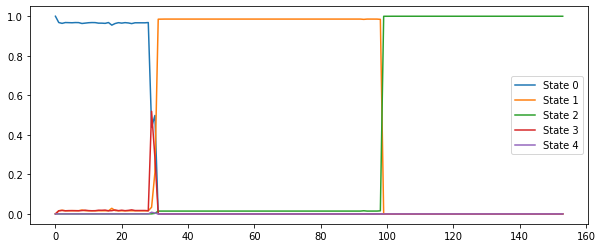

In [49]:
# plot posterior of states for a single test trial
plt.figure(figsize=(10, 4))
for i in range(num_states):
    plt.plot(posterior[:,i], label="State %d" % i)
plt.legend()

## 5. Decode Reach Directions
  
  
For the purposes of this notebook, we are only going to decode reaches to the left and right targets (we excluded trials to other targets during the data formatting above). To so so, we'll call `hmm.filter` on each spike train in our test dataset. We'll then integrate over  window towards the end of the trial (let's say 50 ms) and pick the state that has the highest posterior probability.

Recalling from above, we have assigned the states as follows: 
We will assign our states as follows:

1. Baseline
2. Planning Right
3. Reaching Right
4. Planning Left
5. Reaching Left

In [52]:
# Check accuracy on rightward reaches
window = 50
all_trials = format_spikes(FR, np.arange(FR.shape[-1]))
num_correct = 0
total_test_trials = len(test_right_idx) + len(test_left_idx)

for i in test_right_idx:
    trial = all_trials[i]
    posterior = simple_hmm.filter(trial)
    
    # Integrate posterior probability
    p_right = np.sum(posterior[-window:, 2])
    p_left = np.sum(posterior[-window:, 4])
        
    if p_right > p_left: 
        num_correct += 1
        
# Now check accuracy on leftward reaches
for i in test_left_idx:
    trial = all_trials[i]
    posterior = simple_hmm.filter(trial)
    
    # Integrate posterior probability
    p_right = np.sum(posterior[-window:, 2])
    p_left = np.sum(posterior[-window:, 4])
        
    if p_right < p_left: 
        num_correct += 1
        
print("Percent accuracy on test set %f" % (num_correct / total_test_trials * 100))

Percent accuracy on test set 100.000000
